# Scatter plot


In [1]:
import torch
import deep.model as models
import deep.training as training
import pandas as pd
from tool.preprocessing import DataCollection
from tool.create_dataset import creation
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#Hyperparameters
NUM_RECORD = 20
TOTAL_DIMENSION = NUM_RECORD*6
PROB = 1
BATCH_SIZE=64
NUM_HIDDEN = 1500
LR=5e-5
NUM_EPOCHS = 500


collection = DataCollection(drop_null=True)
gt = collection.get_gt()

X = torch.tensor([]).to(torch.device("cuda:0"))
y = torch.tensor([]).to(torch.device("cuda:0"))

'''
In this part, instead of I have done before, I compute for each device (aligned to hours) the relative ground truth value.
Then I spilt the result into subsequent interval of values and linearize it.
I do this for every device in order to have a dataset of record in which each of those aren't related to anything else.
In the version one I simply take the first part of the dataset as train and the second as test, that obviously is wrong.
'''
for i in collection.get_devices():
    tmp = pd.merge(i,gt,how="inner",on="valid_at").rename(columns={"pm2p5_y":"pm2p5_t","pm2p5_x":"pm2p5"})
    res = creation(tmp,lookback=NUM_RECORD,p=1)
    X = torch.concat([X.clone(),res[0].flatten(-2)])
    y = torch.concat((y.clone(),res[1].flatten(-2)[:,0]))

    

PATH_MODEL = r'./weights_airmlp1700.pth'


device = torch.device("cpu")
model_rest = models.AirMLP_7(num_fin=TOTAL_DIMENSION,num_hidden=NUM_HIDDEN).to(device)
model_rest = torch.load(PATH_MODEL)
model_rest.eval()

c:\Users\Leonardo\anaconda3\envs\generic\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AirMLP_7(
  (net): Sequential(
    (0): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=120, out_features=1500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1500, out_features=1500, bias=True)
    (4): ReLU()
    (5): Linear(in_features=1500, out_features=1500, bias=True)
    (6): ReLU()
    (7): Linear(in_features=1500, out_features=1500, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1500, out_features=1500, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1500, out_features=1500, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1500, out_features=1, bias=True)
  )
)

In [3]:
#drop columns
model = model_rest
test_graph = pd.read_csv(r'.\data\test_graph.csv').reset_index(drop=True)
#round.h
test_graph["valid_at"]= pd.to_datetime(test_graph["valid_at"]).dt.round("H")

#merge with arpa
tmp = pd.merge(test_graph,collection.arpa,how="inner", on="valid_at").rename(columns={"pm2p5_y":"pm2p5_t","pm2p5_x":"pm2p5"})
#create dataset
res = creation(tmp,lookback=NUM_RECORD,p=1)
X_graph = res[0].flatten(-2)
y_arpa = res[1].flatten(-2)[:,0]
#model
model.eval()
y_res = model(X_graph)
#plot

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)


y_res_test = model(X_test)
'''
plt.title(f"Predicted vs arpa")

plt.plot(y_res.cpu().detach().numpy(),'-r', label="predicted")
plt.plot(y_arpa.cpu().detach().numpy(),'-b', label="arpa")
leg = plt.legend(loc='upper center')
plt.xlabel('Days from zero')
plt.ylabel('PM2.5')

plt.show()



plt.title(f"Original vs arpa")
plt.plot(y_arpa.cpu().detach().numpy(),'-b', label="arpa")
plt.plot(test_graph["pm2p5"][20:].reset_index(drop=True),'--g', label="original")
leg = plt.legend(loc='upper center')
plt.xlabel('Days from zero')
plt.ylabel('PM2.5')




plt.show()
'''

'\nplt.title(f"Predicted vs arpa")\n\nplt.plot(y_res.cpu().detach().numpy(),\'-r\', label="predicted")\nplt.plot(y_arpa.cpu().detach().numpy(),\'-b\', label="arpa")\nleg = plt.legend(loc=\'upper center\')\nplt.xlabel(\'Days from zero\')\nplt.ylabel(\'PM2.5\')\n\nplt.show()\n\n\n\nplt.title(f"Original vs arpa")\nplt.plot(y_arpa.cpu().detach().numpy(),\'-b\', label="arpa")\nplt.plot(test_graph["pm2p5"][20:].reset_index(drop=True),\'--g\', label="original")\nleg = plt.legend(loc=\'upper center\')\nplt.xlabel(\'Days from zero\')\nplt.ylabel(\'PM2.5\')\n\n\n\n\nplt.show()\n'

In [5]:
y_test.shape

torch.Size([6057])

In [6]:
y_res_test[:,0].shape

torch.Size([6057])

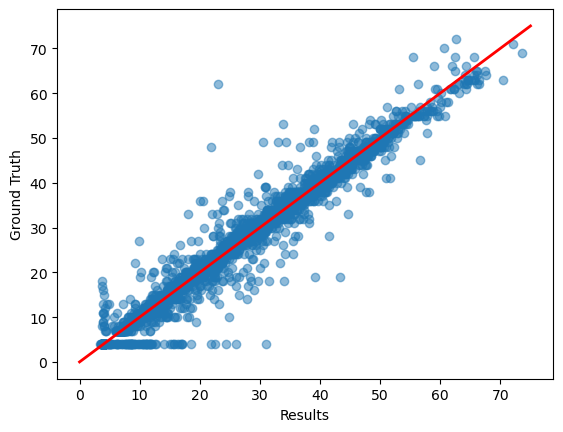

In [9]:
import numpy as np

plt.scatter(y_res_test[:,0].cpu().detach().numpy(), y_test.cpu().detach().numpy(), alpha=0.5)
plt.xlabel('Results')
plt.ylabel('Ground Truth')
plt.plot([0, 75], [0, 75], color = 'red', linewidth = 2)
plt.show()

# Feature Importance

In [11]:
import sys
import gc
import torch.nn as nn
import torch
from torch.nn.utils.weight_norm import weight_norm
from sklearn import preprocessing
import shap
import numpy as np
import joblib
import numpy as np

import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import r2_score

In [12]:
device = torch.device("cuda:0")

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE)
loader_test = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle=False, batch_size=BATCH_SIZE)

In [13]:


e = shap.DeepExplainer(model,X_train[np.random.choice(np.arange(len(X_train)), 1000, replace=False)])

x_samples = X_test[np.random.choice(np.arange(len(X_test)), 1000, replace=False)]

shap_values = e.shap_values(x_samples.to(device))

c:\Users\Leonardo\anaconda3\envs\generic\lib\site-packages\torch\nn\modules\module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
feat_name=list()
for i in range(20):
    rh = f"relative_humidity_{i}"
    temp = f"temperature_{i}"
    pressure = f"pressure_{i}"
    wind_speed =f"wind_speed_{i}"
    cloud_coverage = f"cloud_coverage_{i}"
    pm2p5 = f"pm2p5_{i}"
    feat_name.append(rh)
    feat_name.append(temp)
    feat_name.append(pressure)
    feat_name.append(wind_speed)
    feat_name.append(cloud_coverage)
    feat_name.append(pm2p5)
    
shap.summary_plot(shap_values, features=x_samples, feature_names=feat_name, max_display=20)
 

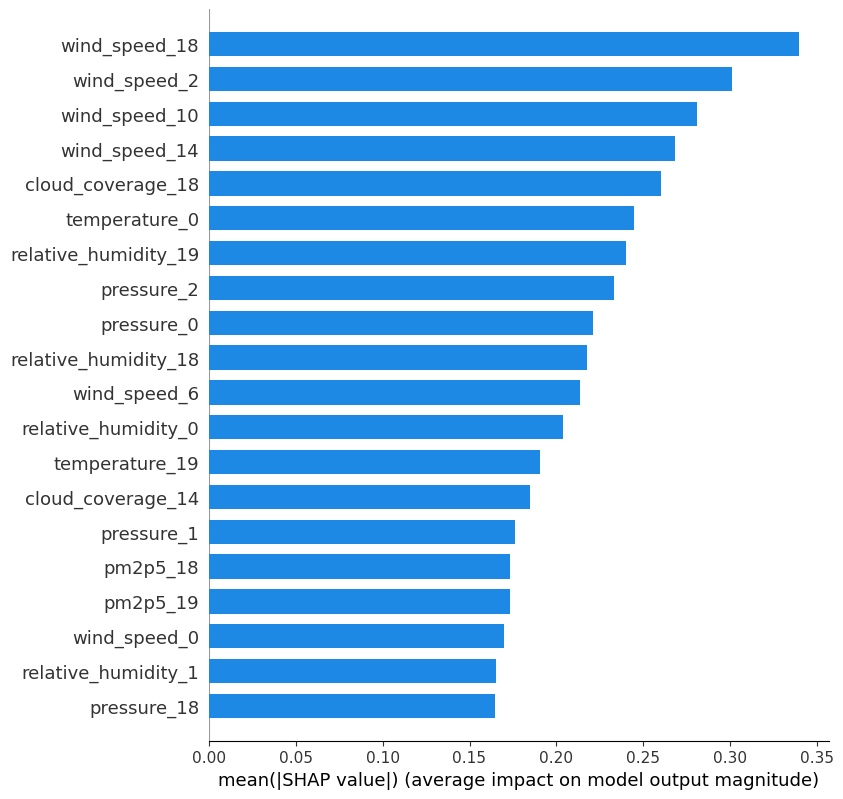

In [34]:
shap.summary_plot(shap_values, features=x_samples.cpu(), feature_names=feat_name, max_display=20, plot_type="bar")


In [22]:
pd.DataFrame(x_samples.cpu(),columns=feat_name)

,relative_humidity_0,temperature_0,pressure_0,wind_speed_0,cloud_coverage_0,pm2p5_0,relative_humidity_1,temperature_1,pressure_1,wind_speed_1,...,pressure_18,wind_speed_18,cloud_coverage_18,pm2p5_18,relative_humidity_19,temperature_19,pressure_19,wind_speed_19,cloud_coverage_19,pm2p5_19
0,67.730003,17.030001,1016.0,2.57,0.0,8.030000,68.309998,16.639999,1017.0,2.06,...,1017.0,3.09,0.0,26.780001,79.400002,13.24,1017.0,3.09,0.0,31.700001
1,59.000000,13.850000,1010.0,2.06,0.0,15.580000,59.000000,13.850000,1010.0,2.06,...,1006.0,2.06,0.0,19.370001,47.000000,15.57,1006.0,2.06,0.0,22.340000
2,44.060001,8.710000,1009.0,1.54,0.0,14.970000,43.180000,8.550000,1009.0,1.54,...,1008.0,2.06,75.0,27.959999,54.869999,7.11,1008.0,2.57,75.0,31.830000
3,82.410004,24.639999,1022.0,1.54,0.0,14.830000,81.129997,23.719999,1022.0,1.54,...,1021.0,1.54,0.0,8.740000,52.919998,25.74,1021.0,1.54,0.0,11.430000
4,28.680000,5.880000,1033.0,2.06,0.0,25.690001,30.420000,6.950000,1033.0,2.06,...,1034.0,2.06,0.0,39.669998,40.919998,0.33,1034.0,2.06,0.0,46.009998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,78.580002,13.300000,1028.0,3.09,0.0,91.000000,79.250000,13.080000,1028.0,3.09,...,1026.0,0.51,0.0,209.839996,84.239998,11.87,1026.0,0.51,0.0,168.220001
996,29.000000,17.879999,1013.0,2.06,0.0,6.140000,29.000000,17.879999,1013.0,2.06,...,1007.0,2.57,0.0,14.340000,60.000000,14.64,1007.0,2.57,0.0,10.490000
997,37.000000,8.350000,1028.0,1.03,0.0,35.410000,37.000000,8.350000,1028.0,1.03,...,1027.0,0.45,0.0,18.740000,34.000000,9.72,1027.0,0.45,0.0,13.940000
998,84.959999,15.670000,1020.0,1.34,75.0,56.349998,85.500000,15.790000,1020.0,1.34,...,1018.0,1.03,75.0,44.400002,86.559998,16.50,1018.0,1.03,75.0,41.689999
